<div align="center" style="font-size: 32px; font-weight:bold">
IND5003_A1
</div>
<br>
<div align="center" style="font-size: 24px;">
WU QILONG<br>E1124649@u.nus.edu<br>A0274903B
</div>

# Instructions

1. This assignment is worth 5% of the final grade.
2. Insert cells (code or markdown, as appropriate) below each question and fill in your answers there.
2. You are required to work on this individually. Any form of plagiarism will result in 0.
3. Please submit your notebook file (name it ``IND5003_A1_<Your_Name>.ipynb``) through Canvas before **17th Sep 2023 23:59hrs**.

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns


def check_normality(pd_series):
    """Creates a panel of three plots for checking Normality.
    
    The input is a pandas series of real numbers.
    
    The output is a plot figure with three subplots - a boxplot, a histogram and 
    a qq-plot.
    """
    plt.figure(1, figsize=(15, 4))
    plt.subplot(131)
    pd_series.plot(kind='box')

    plt.subplot(132)
    # pd_series.hist(grid=False);
    sns.histplot(pd_series, bins=10, kde=True)

    plt.subplot(133)
    stats.probplot(pd_series, plot=plt)

# Question 1

The file `resale_flat_prices.csv` contains resale flat prices in Singapore from January 2017 onwards. The file `town_type_region.xlsx` contains the classification of each town as *mature* or *non-mature* and each town's geographical region (*north*, *north-east*, *east*, *west*, or *central*). Use these two files and choose the appropriate hypothesis test to perform the five steps for each question. to answer the following questions:

In [8]:
def years_trans(time_string):
    lst = time_string.split()
    if 'years' in lst:
        if 'months' in lst:
            return int(lst[0]) + int(lst[2]) / 12
        else:
            return int(lst[0])
    else:
        return 0

data1 = pd.read_csv('../data/resale_flat_prices.csv')
data2 = pd.read_excel('../data/town_type_region.xlsx')
data = pd.merge(left=data1, right=data2, how='left', on='town')
data['remaining_lease_years'] = data['remaining_lease'].apply(years_trans)

In [9]:
data.head(3)

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,lease_commence_date,remaining_lease,resale_price,type,region,remaining_lease_years
0,2017-01,ANG MO KIO,2 ROOM,406,ANG MO KIO AVE 10,10 TO 12,44.0,Improved,1979,61 years 04 months,232000.0,mature,north-east,61.333333
1,2017-01,ANG MO KIO,3 ROOM,108,ANG MO KIO AVE 4,01 TO 03,67.0,New Generation,1978,60 years 07 months,250000.0,mature,north-east,60.583333
2,2017-01,ANG MO KIO,3 ROOM,602,ANG MO KIO AVE 5,01 TO 03,67.0,New Generation,1980,62 years 05 months,262000.0,mature,north-east,62.416667


## 1.1 
In the period January 2022 to June 2022, was the mean resale price **per square metre per year of remaining lease** of 4 ROOM flats the same for all geographical regions?

### Data Proprocessing

In [10]:
dt1 = data[('2022-01' <= data['month']) & (data['month'] <= '2022-06') &
           (data['flat_type'] == '4 ROOM')].reset_index(drop=True)
dt1['resale_price_per_sqm_rlyear'] = dt1['resale_price'] / dt1[
    'remaining_lease_years'] / dt1['floor_area_sqm']
dt1 = dt1[['region', 'resale_price_per_sqm_rlyear']]
dt1.groupby('region')['resale_price_per_sqm_rlyear'].mean()

region
central       99.383641
east          75.912790
north         63.382835
north-east    68.816210
west          67.386625
Name: resale_price_per_sqm_rlyear, dtype: float64

In [11]:
dt1.head(3)

,region,resale_price_per_sqm_rlyear
0,north-east,94.720497
1,north-east,86.363082
2,north-east,81.996435


### Hypothesis tests

#### Step 1: Check Assumptions

In [12]:
res = dt1.groupby('region', group_keys=True)['resale_price_per_sqm_rlyear'].apply(lambda x: x - np.mean(x))
res_index = res.index.droplevel(0)
res_values = res.values
dt1['res'] = pd.Series(res_values, res_index)
dt1

,region,resale_price_per_sqm_rlyear,res
0,north-east,94.720497,25.904287
1,north-east,86.363082,17.546872
2,north-east,81.996435,13.180225
3,north-east,78.011406,9.195196
4,north-east,80.489210,11.673000
...,...,...,...
5582,north,79.365079,15.982244
5583,north,75.641517,12.258682
5584,north,74.404762,11.021927
5585,north,94.440485,31.057650


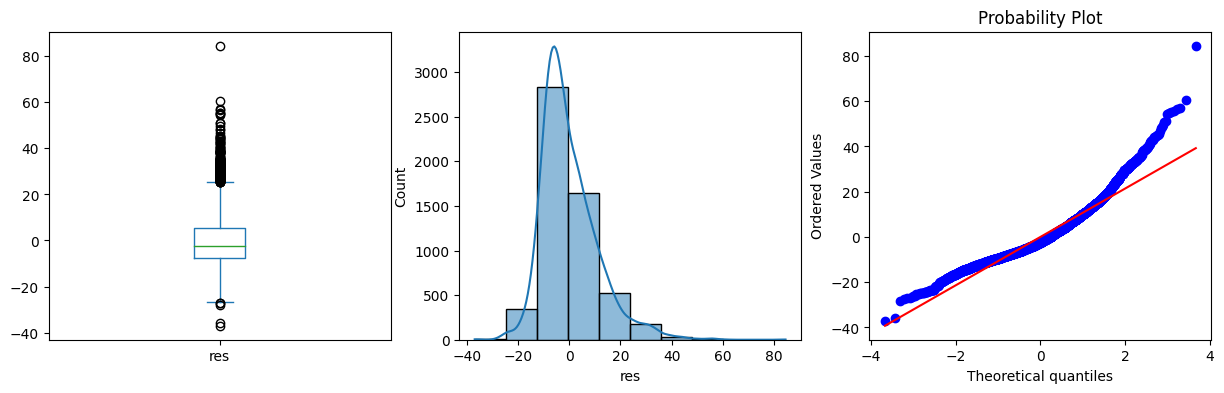

In [13]:
check_normality(dt1.res)

In the normality test, we observed numerous outliers in the box plot. The distribution plot shows skewness and is not symmetrical. In the QQ plot, it is evident that the data points do not all lie on a straight line but start to deviate significantly in the region where the 'res' value ranges from 20-60. Therefore, this distribution is not normally distributed, and we use the Kruskal-Wallis test for evaluation.

#### Step 2: Null and Alternative Hypotheses -- (Kruskal-Wallis test)

The statement of the hypotheses in this case would be:

the null hypothesis can be stated as:
$$
H_0 : \mu_1 = \mu_2 = \cdots = \mu_k
$$

The alternative hypothesis is best stated in words:
$$
H_1 : \text{At least two of group means are different}
$$

Remember that null and alternative hypotheses cannot have any overlap in the regions that they specify.

#### Steps 3 & 4: Compute test statistic and $p$-value -- (Kruskal-Wallis test)

The Kruskal-Wallis test's statistic, $ H $, is computed based on the ranks of the data. Given $ k $ samples, the formula for the statistic $ H $ is:

\begin{equation*}
H = \frac{12}{N(N+1)} \sum_{i=1}^{k} \frac{R_i^2}{n_i} - 3(N+1)
\end{equation*}

Where:
- $ N $ is the total number of observations across all samples.
- $ R_i $ is the rank sum for the $ i^{th} $ sample.
- $ n_i $ is the size of the $ i^{th} $ sample.
- $ k $ is the number of groups.

This statistic approximately follows a chi-squared distribution for large samples, with degrees of freedom $ k - 1 $.


In [14]:
from scipy.stats import kruskal

regions = [
    dt1[dt1['region'] == i]['res'].to_numpy() for i in dt1['region'].unique()
]
statistic, p_value = kruskal(*regions)

print(f"Statistic: {statistic}")
print(f"P-value: {p_value}")

Statistic: 32.7945951761432
P-value: 1.3159092256056765e-06


#### Step 5: Conclusion from $p$-Value

We would conclude that we have strong evidence against the null hypothesis and that At least one region's mean resale price issignificantly different from the others.

In [15]:
# Determine the outcome based on the p-value and a significance level (0.05)
alpha = 0.05
if p_value < alpha:
    print(
        "Reject the null hypothesis: At least one region's mean resale price is" \
        "significantly different from the others."
    )
else:
    print(
        "Fail to reject the null hypothesis: The mean resale prices across regions might be the same."
    )

Reject the null hypothesis: At least one region's mean resale price issignificantly different from the others.


## 1.2
In the period July 2022 to December 2022, was there any difference in the distribution of geographical regions for each resale flat type? (Please **omit** 1 ROOM and MULTI-GENERATION flats from this analysis.)

### Data Preprocessing

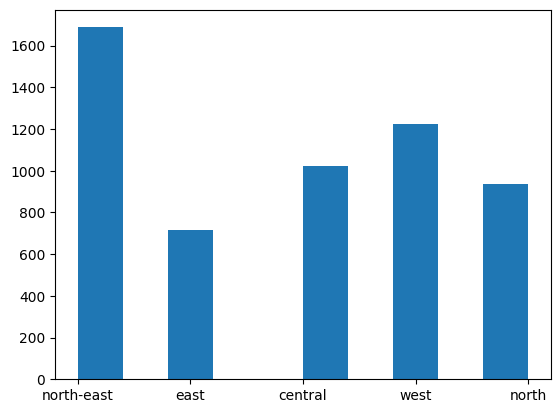

In [16]:
plt.hist(dt1['region'])
plt.show()

In [17]:
omit = ['1 ROOM', 'MULTI-GENERATION']
dt2 = data[(data['month'] >= '2022-07') & (data['month'] <= '2022-12') &
           (~data['flat_type'].isin(omit))].reset_index(drop=True)
dt2 = dt2[['flat_type', 'region']]
table = pd.crosstab(dt2['flat_type'], dt2['region'])

In [18]:
table

region,central,east,north,north-east,west
flat_type,,,,,
2 ROOM,48,19,84,67,38
3 ROOM,1036,483,484,666,611
4 ROOM,948,711,1199,1635,1229
5 ROOM,450,491,624,977,806
EXECUTIVE,74,251,179,180,270


### Hypothesis tests

In [19]:
chi2, p, dof, exp = stats.chi2_contingency(table)
print("chi-square statistic:", chi2)
print("p-value:",p)
print("Degrees of freedom:", dof)
print("Expected frequencies:", "\n", exp)

chi-square statistic: 734.1655738392806
p-value: 6.874279549042282e-146
Degrees of freedom: 16
Expected frequencies: 
 [[  48.25486726   36.90855457   48.51917404   66.54867257   55.76873156]
 [ 618.26548673  472.89085546  621.6519174   852.65486726  714.53687316]
 [1078.57168142  824.96386431 1084.47935103 1487.46681416 1246.51828909]
 [ 631.08318584  482.69469027  634.53982301  870.33185841  729.35044248]
 [ 179.82477876  137.5420354   180.80973451  247.99778761  207.82566372]]


###### Question 2

The secretary problem *in its simplest form* has the following features.

1. There is one secretarial position available.
2. The number $n$ of applicants is known.
3. The applicants are interviewed sequentially in random order, each order being equally likely.
4. It is assumed that you can rank all the applicants from best to worst without tties. The decision to accept or reject an applicant must be based only on the relative ranks of those applicants interviewed so far.
5. An applicant once rejected cannot later be recalled.
6. You are very particular and will be satisfied with nothing but the very best.

This basic problem has a remarkably simple solution. First, one shows that attention can be restricted to the class of rules that for some integer $r \ge 1$ rejects the first $r - 1$ applicants, and then chooses the next applicant who is best in the relative ranking of the observed applicants. For such a rule, the probability, $p_n(r)$, of selecting the best applicant is $1/n$ for $r = 1$, and for $r > 1$,
\begin{equation*}
  p_n(r) = \frac{r - 1}{n} \sum_{i=r}^n \frac{1}{i - 1}.
\end{equation*}
The optimal $r$ is the one that maximises this probability. For small values of $n$, the optimal $r$ can easily be computed. For example, when $n = 11$, the function $p_n(r)$ takes on its maximum value when $r = 5$.

When $n = 11$ and using the optimal solution outlined above, use **simulation** to answer the following questions:

## 2.1
What is the probability that you **could not find an acceptable applicant?**

In this case, we divide the problem into two cases:

* rule1: we accept people who is best in the relative ranking of the observed applicants 
* rule2: we accept people who are the best of all possible applicants 

In [152]:
r = 5
num_people = 11  # batchsize of people
test_times = 1000000  # num of simulation times
results = []
best_pos = []
rule1_accept_freq = []
rule2_accept_freq = []
np.random.seed(23)

for i in range(test_times):
    single_result = np.arange(1, num_people + 1)
    np.random.shuffle(single_result)
    best = np.argmax(single_result)
    
    # rule1: we accept people who is best in the relative ranking of the observed applicants
    rule1_accept = [
        1 if single_result[i - 1] > single_result[:i - 1].max() else 0
        for i in range(2, num_people + 1)
    ]

    # rule2: we accept people who are the best of all possible applicants
    rule2_accept = []
    for i in range(num_people):
        if single_result[i] == num_people:
            rule2_accept.append(1)
        elif single_result[i] == (num_people - 1):
            rule2_accept.append(-1)
        else:
            rule2_accept.append(0)

    best_pos.append(best)
    rule1_accept_freq.append(rule1_accept)
    rule2_accept_freq.append(rule2_accept)
    results.append(single_result)

arr_result = np.array(results)
arr_best_pos = np.array(best_pos)
arr_rule1_accept_freq = np.array(rule1_accept_freq)
arr_rule2_accept_freq = np.array(rule2_accept_freq)

### Rule1: We accept people who is best in the relative ranking of the observed applicants, so we cannot find an acceptable people when we the person is not better than before.

In [180]:
p1 = np.count_nonzero(np.sum(arr_rule1_accept_freq[:, r - 2:], axis=1), 0) / test_times
print('P1:', p1)

P1: 0.182222


### Rule2: We accept people who is best of all possible applicants, so we cannot find an acceptable people when we the person is not the best of all

#### Senario 1 : We choose when we reject the second best before, and then choose the best after that.

In [194]:
r = 5
result = 0
for i in range(r - 1, num_people):
    temp = np.sum((np.sum(arr_rule2_accept_freq[:, 0:r - 1], axis=1) == -1)
                  & (arr_rule2_accept_freq[:, i] == 1))
    result += temp
p2_1 = result / test_times
print('P2-1:', p2_1)

P2-1: 0.254349


#### Senario 2: We choose when we just find the best.

In [195]:
arr_rule22_accept_freq = np.where(arr_rule2_accept_freq == -1, 0, arr_rule2_accept_freq)
p2_2 = 1 - np.sum(np.sum(arr_rule22_accept_freq, axis=0)[r - 1:]) / test_times
print('P2-2:', p2_2)

P2-2: 0.36293299999999995


## 2.2
How many applicants do you expect to interview **by the time you accept an applicant?**

#### If we accept only best applicant

In [199]:
print("We tend to interview: {0} people".format(np.round(np.where(arr_rule2_accept_freq==1)[1].mean() + 1)))

We tend to interview: 6.0 people
